In [1]:
import os
import datetime

import pandas as pd
import geopandas as gpd
import numpy as np

import osmnx as ox

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
style.use('seaborn-white')
output_folder = 'data'

# Parameters

In [3]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???

place_name = 'Amsterdam'
country = 'NLD'
sub_folder = str(place_name).replace(' ', '')+'_14Apr2022'
local_crs = 'EPSG:28992'
place_extra = 0

In [4]:
children = True   # only when country = 'NLD'
grid = True       # only when country = 'NLD'

perbuilding = False
estimation = 'unweighted'
min_area = 40

buffer = 800

# load city extent

In [5]:
place = ox.geocode_to_gdf(place_name).to_crs(local_crs)
if place_extra:
    place['geometry'] = place.buffer(place_extra, join_style=2)

# Load residence data

In [6]:
if perbuilding:
    residences_non_excl = gpd.read_file(os.path.join(os.path.join(output_folder, sub_folder), 'residences_non_excl.geojson'))
    residences_non_excl.crs = local_crs
    
    rsd_filtered = residences_non_excl.copy()
    
    rsd_filtered = rsd_filtered[(rsd_filtered.geom_type == 'Polygon')|(rsd_filtered.geom_type == 'MultiPolygon')]
    rsd_filtered['building_footprint_area'] = rsd_filtered.geometry.area
    rsd_filtered['building_count'] = 1
    
    rsd_filtered = rsd_filtered[rsd_filtered['building_footprint_area']>=min_area]
    
    rsd_filtered['polygon'] = rsd_filtered.geometry
    rsd_filtered['centroid'] = rsd_filtered.geometry.centroid
    rsd_filtered = rsd_filtered.set_geometry(rsd_filtered.centroid)

In [7]:
extent = place.buffer(buffer, join_style=2)
bbox = extent.to_crs(local_crs).total_bounds
bbox = (bbox[0], bbox[1], bbox[2], bbox[3])

# National population statistics data

National datasets downloaded via

- for The Netherlands
    - https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2021
    - or https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/kaart-van-100-meter-bij-100-meter-met-statistieken
- for Spain
    - geometries 2018 from https://www.ine.es/ss/Satellite?c=Page&p=1259952026632&pagename=ProductosYServicios%2FPYSLayout&cid=1259952026632&L=1
    - population data 2018 (= most recent) from https://www.ine.es/buscar/searchResults.do?Menu_botonBuscador=&searchType=DEF_SEARCH&startat=0&L=1&searchString=demographic%20indicators
- for Sweden
    - geometries 2018 (= most recent) from https://scb.se/vara-tjanster/oppna-data/oppna-geodata/deso--demografiska-statistikomraden/
    - population data 2018 from https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__BE__BE0101__BE0101Y/FolkmDesoAldKonN/
    

In [8]:
# population = gpd.read_file(os.path.join(output_folder, 'population/NLD/cbs_vk100_2021_v1.gpkg'), bbox=bbox)

In [9]:
if country == 'NLD':
    if grid:
        population = gpd.read_file(os.path.join(output_folder, 'population/NLD/cbs_vk100_2021_v1.gpkg'), bbox=bbox)
        col_pop = 'aantal_inwoners'
        col_cld = 'aantal_inwoners_0_tot_15_jaar'
        col_adl = 'aantal_inwoners_15_tot_25_jaar'
        nan_val = -99997
    else:
        population = gpd.read_file(os.path.join(output_folder, 'population/NLD/buurt_2020_v1.shp'), bbox=bbox)    
        population = population[(population['OPP_LAND'] > 0)]
        col_pop = 'AANT_INW'
        col_cld = 'P_00_14_JR'
        col_adl = 'P_15_24_JR'
        nan_val = -99999999
    population = population.replace({col_pop: nan_val}, value=0)
    population['pop_count'] = population[col_pop]
    population['pop_density'] = population[col_pop] / population.geometry.area
    if children:
        # handle nan values
        population = population.replace({col_cld: nan_val}, value=0)
        population = population.replace({col_adl: nan_val}, value=0)
        if grid:
            # numbers
            population['cld_count'] = population[col_cld]
            population['adl_count'] = population[col_adl]
        else:
            # percentages
            population['cld_count'] = population[col_pop] * (population[col_cld] / 100)
            population['adl_count'] = population[col_pop] * (population[col_adl] / 100)
    
elif country == 'ESP':
    # load shapefile with census geometries
    geometries = gpd.read_file(os.path.join(output_folder, 'population/ESP/SECC_CE_20180101.shp'), bbox=bbox)
    # load table with population data
    table = pd.read_excel(os.path.join(output_folder, 'population/ESP/{}_preprocessed.xlsx'.format(place_name)))
    table = table.replace(' ', np.nan)
    table['CUSEC'] = table['code_name'].str.split(expand=True)[0]
    # merge them and calculate density
    population = geometries.merge(table, on='CUSEC', how='left')
    population['pop_count'] = population['Population']
    population['pop_density'] = population['Population'] / population.geometry.area

elif country == 'SWE':
    # load shapefile with census geometries
    geometries = gpd.read_file(os.path.join(output_folder, 'population/SWE/DeSO_2018_v2.gpkg'), bbox=bbox)
#     if place_name == 'Malmo':
#         geometries = geometries[geometries['kommunnamn'] == 'Malmö']
#     elif place_name == 'Goteborg':
#         geometries = geometries[geometries['kommunnamn'] == 'Göteborg']
#     else:
#         geometries = geometries[geometries['kommunnamn'] == str(place_name)]
    # load table with population data
    table = pd.read_excel(os.path.join(output_folder, 'population/SWE/deso_{}_2018_totalpopulation.xlsx'.format(place_name.lower())), skiprows=2)
    table['deso'] = table.deso.str.replace(' ', '')
    # merge them and calculate density
    population = geometries.merge(table, on='deso', how='left')
    population['pop_count'] = population['2018']
    population['pop_density'] = population['2018'] / population.geometry.area

In [10]:
if not perbuilding:
    rsd_pop = population.set_geometry(population.centroid)

In [11]:
rsd_pop = gpd.clip(rsd_pop, extent)

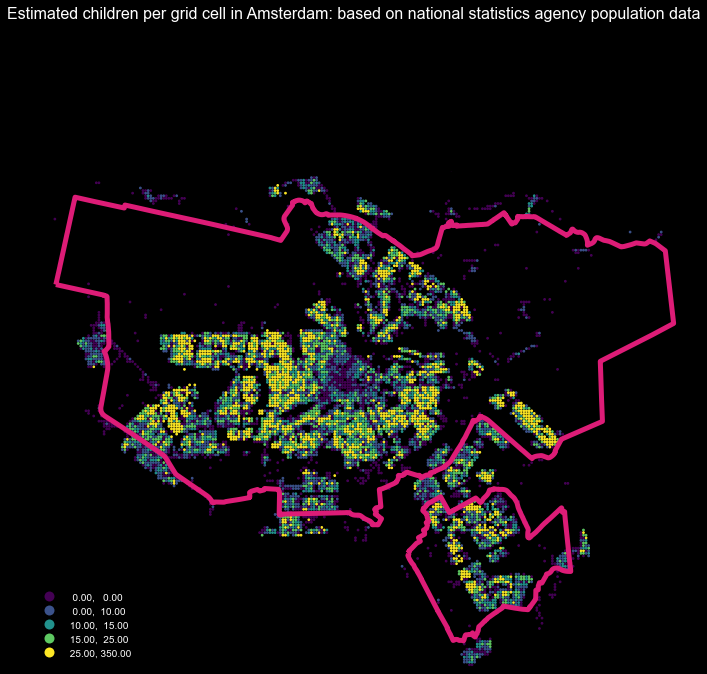

In [12]:
if not perbuilding:
    style.use('dark_background')

    if country == 'NLD' and children:

        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
        fig.suptitle('Estimated children per grid cell in {}: based on national statistics agency population data'.format(place_name), fontsize=16)
        
        rsd_pop.plot(ax=axs, column=col_cld, cmap='viridis', markersize=3, scheme='quantiles', legend=True)
        place.plot(ax=axs, figsize=(12, 12), facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5, zorder=6)

        bbox = place.total_bounds
        margin = 1000
        xlim = ([bbox[0]-margin, bbox[2]+margin])
        ylim = ([bbox[1]-margin, bbox[3]+margin])
        axs.set_xlim(xlim)
        axs.set_ylim(ylim)
        plt.axis('off')

        plt.show()

# Population estimation per building

In [13]:
if perbuilding:
    rsd_pop = gpd.sjoin(rsd_filtered, population, how='left', op='intersects')

In [14]:
if perbuilding:
    if country == 'NLD':
        if grid:
            code = 'crs28992res100m'
        else:
            code = 'BU_CODE'
    elif country == 'ESP':
        code = 'CUSEC'
    elif country == 'SWE':
        code = 'deso'

    total_footprints = rsd_pop[[code, 'building_footprint_area', 'building_count']]
    total_footprints = total_footprints.groupby(code).agg('sum')
    total_footprints = total_footprints.rename(columns = {
        'building_footprint_area': 'total_building_footprint_area',
        'building_count': 'total_building_count'})
    rsd_pop = total_footprints.merge(rsd_pop, on=code, how='left')

In [15]:
if perbuilding:
    if estimation == 'weighted':
        rsd_pop['pop_est'] = ((rsd_pop['pop_count'] / rsd_pop['total_building_footprint_area']) * rsd_pop['building_footprint_area']).astype(float)
        if country == 'NLD' and children:
            rsd_pop['cld_est'] = ((rsd_pop['cld_count'] / rsd_pop['total_building_footprint_area']) * rsd_pop['building_footprint_area']).astype(float)
            rsd_pop['adl_est'] = ((rsd_pop['adl_count'] / rsd_pop['total_building_footprint_area']) * rsd_pop['building_footprint_area']).astype(float)

    elif estimation == 'unweighted':
        rsd_pop['pop_est'] = (rsd_pop['pop_count'] / rsd_pop['total_building_count']).astype(float)
        if country == 'NLD' and children:
            rsd_pop['cld_est'] = (rsd_pop['cld_count'] / rsd_pop['total_building_count']).astype(float)
            rsd_pop['adl_est'] = (rsd_pop['adl_count'] / rsd_pop['total_building_count']).astype(float)

In [16]:
if perbuilding:
    rsd_pop = rsd_pop.set_geometry(rsd_pop.polygon)

In [17]:
if perbuilding:
    style.use('dark_background')

    if country == 'NLD' and children:

        upper = max(max(rsd_pop['cld_est']), max(rsd_pop['adl_est']))

        bins = [0, 0.5, 1, 2, 5, upper]

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
        fig.suptitle('Estimated population per building in {}: based on national statistics agency population data'.format(place_name), fontsize=16)

        rsd_pop.plot(ax=axs[0], column='cld_est', cmap='plasma', scheme='User_Defined', classification_kwds=dict(bins=bins), legend=True)
        place.to_crs(rsd_pop.crs).plot(ax=axs[0], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)
        axs[0].set_title('Estimated children (age 0-14) per building')

        rsd_pop.plot(ax=axs[1], column='adl_est', cmap='plasma', scheme='User_Defined', classification_kwds=dict(bins=bins), legend=True)
        place.to_crs(rsd_pop.crs).plot(ax=axs[1], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)
        axs[1].set_title('Estimated adolescents (age 15-24) per building')

        for ax in axs:
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

        plt.show()

In [18]:
if perbuilding:
    quantiles = rsd_pop[rsd_pop['cld_est']>0]['cld_est'].quantile([0, 0.25, 0.5, 0.75, 1])
    
    cmap = plt.cm.get_cmap('plasma')
    
    # create legend
    output_legend_handles = [
        mpatches.Patch(color='#404040', label='0 children'),
        mpatches.Patch(color=cmap(0.0), label='0.1 to {} children'.format((round(quantiles[0.25], 1)))),
        mpatches.Patch(color=cmap(0.5), label='{} to {} children'.format((round(quantiles[0.25], 1)+0.1), (round(quantiles[0.75], 1)))),
        mpatches.Patch(color=cmap(1.0), label='{} to {} children'.format(round(round(quantiles[0.75], 1)+0.1, 1), (round(quantiles[1], 1)))),
        mlines.Line2D([], [], color='#dd1c77', linestyle='-', linewidth=3, label='Official administrative boundary')
    ]

In [19]:
if perbuilding:
    style.use('dark_background')

    if country == 'NLD' and children:

        upper = max(max(rsd_pop['cld_est']), max(rsd_pop['adl_est']))

        bins = [0, 0.5, 1, 2, 5, upper]

        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
        fig.suptitle('Estimated children per building in {}: based on national statistics agency population data'.format(place_name), fontsize=16)

        # population.plot(ax=axs, column='cld_count', scheme='quantiles', cmap=cmap, alpha=0.4)
        rsd_pop[rsd_pop['cld_est']==0].plot(ax=axs, color='#404040')
        rsd_pop[rsd_pop['cld_est']>0].plot(ax=axs, column='cld_est', cmap=cmap, scheme='quantiles')
        place.to_crs(rsd_pop.crs).plot(ax=axs, facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=3)
        axs.set_title('Estimated children (age 0-14) per building')
        axs.legend(handles=output_legend_handles, loc='upper right')

        bbox = place.total_bounds
        margin = 1000
        xlim = ([bbox[0]-margin, bbox[2]+margin])
        ylim = ([bbox[1]-margin, bbox[3]+margin])
        axs.set_xlim(xlim)
        axs.set_ylim(ylim)
        plt.axis('off')

        plt.show()

#  Store output data

In [20]:
output_sub_folder = os.path.join(output_folder, sub_folder)

In [21]:
output_file = os.path.join(output_sub_folder, 'residences_population.geojson')
rsd_pop = rsd_pop.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
rsd_pop.to_file(output_file, driver='GeoJSON')